# ZARR - OpenVisus

This notebooks shows how it would be possible to use OpenVisus with ZARR

Links:
- https://zarr.readthedocs.io/en/stable/tutorial.html
- https://zarr.readthedocs.io/en/stable/api/storage.html
- https://filesystem-spec.readthedocs.io/en/latest/features.html#caching-files-locally
- https://github.com/zarr-developers/zarr-python

Import Python packages and define some utilities

In [31]:
import os,sys,uuid,errno,shutil
import numpy as np
from PIL import Image
from numcodecs.compat import ensure_contiguous_ndarray_like
import matplotlib.pyplot as plt

def ShowImage(data):
  fig = plt.figure()
  ax = fig.add_subplot(1,1,1)
  img=ax.imshow(data, origin='lower', )
  plt.colorbar(img,ax=ax)
  plt.show()
 

import zarr
from zarr.storage import Store
from zarr.storage import array_meta_key
from zarr.errors import MetadataError, BadCompressorError, ContainsArrayError, ContainsGroupError, FSPathExistNotDir, ReadOnlyError
from zarr.util import retry_call

Create a test ZARR 2D array just to inspect its internal data

After the execution of the cell you will see a `.zarray` file containing array metadata in JSON format

Type               : zarr.core.Array
Data type          : int32
Shape              : (1024, 1024)
Chunk shape        : (256, 256)
Order              : C
Read-only          : False
Compressor         : None
Store type         : zarr.storage.DirectoryStore
No. bytes          : 4194304 (4.0M)
No. bytes stored   : 225
Storage ratio      : 18641.4
Chunks initialized : 0/16



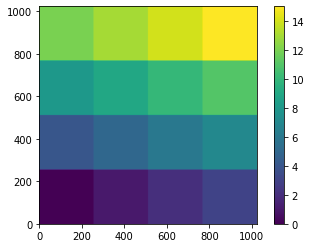

In [33]:
shape=(1024,1024)
chunks=(256,256)
ds = zarr.open('test1/zarr.storage.DirectoryStore/example.zarr',  mode='w', shape=shape, chunks=chunks, dtype='i4', compressor=None)
print(ds.info)

# write a single value for a chunk so it's easier to debug
def WriteChunks(ds):
  ChunkId=0
  for Y1 in range(0,ds.shape[0],ds.chunks[0]):
      for X1 in range(0,ds.shape[1],ds.chunks[1]):
          Y2=Y1+ds.chunks[0]
          X2=X1+ds.chunks[1]
          ds[Y1:Y2,X1:X2]=np.full(ds.chunks, ChunkId, dtype='i4')
          ChunkId+=1
WriteChunks(ds)

ShowImage(ds[:,:])

You can see how internally ZARR is handling the storage (called `Store` in ZARR, `Access`,`BlockQuery` on OpenVisus)

NOTE:
- DirectoryStore is defined [here](https://github.com/zarr-developers/zarr-python/blob/main/zarr/storage.py)
- I am using zarr v2 here which does NOT support multi-resolution
- zarr v3 is in draft, and should support multi-resolution

This class is useful to inspect the call stack of a ZARR store.

rmdir(self,) -> ret=None
__setitem__(key='.zarray', type-value=<class 'bytes'> -> ret=None
__getitem__(key='.zarray') -> ret-type=<class 'bytes'>
__setitem__(key='0.0', type-value=<class 'numpy.ndarray'> -> ret=None
__setitem__(key='0.1', type-value=<class 'numpy.ndarray'> -> ret=None
__setitem__(key='0.2', type-value=<class 'numpy.ndarray'> -> ret=None
__setitem__(key='0.3', type-value=<class 'numpy.ndarray'> -> ret=None
__setitem__(key='1.0', type-value=<class 'numpy.ndarray'> -> ret=None
__setitem__(key='1.1', type-value=<class 'numpy.ndarray'> -> ret=None
__setitem__(key='1.2', type-value=<class 'numpy.ndarray'> -> ret=None
__setitem__(key='1.3', type-value=<class 'numpy.ndarray'> -> ret=None
__setitem__(key='2.0', type-value=<class 'numpy.ndarray'> -> ret=None
__setitem__(key='2.1', type-value=<class 'numpy.ndarray'> -> ret=None
__setitem__(key='2.2', type-value=<class 'numpy.ndarray'> -> ret=None
__setitem__(key='2.3', type-value=<class 'numpy.ndarray'> -> ret=None
__setitem__(ke

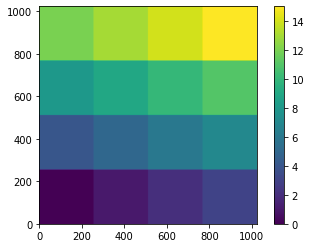

In [38]:
# //////////////////////////////////////////////////
class ProxyDirectoryStore(Store):

	# constructor
  def __init__(self, path):
    self.store = zarr.DirectoryStore(path)

  # __eq__
  def __eq__(self, other):
    return (isinstance(other, ProxyDirectoryStore) and self.store == other.store)

	# rmdir
  def rmdir(self, path=None):
    print(f"rmdir(self,{path})",end=" -> ")
    ret= self.store.rmdir(path)
    print(f"ret={ret}")
    return ret

	# clear
  def clear(self):
    print(f"clear()",end=" -> ")
    ret= self.store.clear()
    print(f"ret={ret}")
    return ret

	# __getitem__
  def __getitem__(self, key):
    print(f"__getitem__(key={repr(key)})",end=" -> ")
    ret= self.store.__getitem__(key)
    print(f"ret-type={type(ret)}")
    return ret

  # __setitem__
  def __setitem__(self, key, value):
    print(f"__setitem__(key={repr(key)}, type-value={type(value)}",end=" -> ")
    ret= self.store.__setitem__(key,value)
    print(f"ret={ret}")
    return ret
    
	# __delitem__
  def __delitem__(self, key):
    print(f"__delitem__(key={repr(key)})",end=" -> ")
    ret= self.store.__delitem__(key)
    print(f"ret={ret}")
    return ret

	# __contains__
  def __contains__(self, key):
    print(f"__contains__(key={repr(key)})",end=" -> ")
    ret= self.store.__contains__(key)
    print(f"ret={ret}")
    return ret
  
	# keys
  def keys(self):
    print(f"keys()",end=" -> ")
    ret= self.store.keys()
    print(f"ret={ret}")
    return ret

	# __iter__
  def __iter__(self):
    print(f"__iter__()",end=" -> ")
    ret= self.store.__iter__()
    print(f"ret={ret}")
    return ret

	# __len__
  def __len__(self):
    print(f"__len__()",end=" -> ")
    ret= self.store.__len__()
    print(f"ret={ret}")
    return ret

	# listdir
  def listdir(self, path=None):
    print(f"listdir(path={path})",end=" -> ")
    ret= self.store.listdir(path)
    print(f"ret={ret}")
    return ret

	# rename
  def rename(self, src_path, dst_path):
    print(f"rename(src_path={src_path},dst_path={dst_path})",end=" -> ")
    ret= self.store.rename(src_path, dst_path)
    print(f"ret={ret}")
    return ret

	# getsize
  def getsize(self, path=None):
    print(f"getsize(path={path})",end=" -> ")
    ret=self.store.getsize(path) 
    print(f"ret={ret}")
    return ret


zarr_filename='test1/ProxyDirectoryStore/example.zarr'

# example of writing toi the pass-through directory store
ds = zarr.open(ProxyDirectoryStore(zarr_filename),  mode='w', shape=shape,  chunks=chunks,  dtype='i4', compressor=None,)
WriteChunks(ds)

# example of reading from the pass-throught directory store
ds = zarr.open(ProxyDirectoryStore(zarr_filename),  mode='r')
print(ds.info)
ShowImage(ds[:,:])

Here we create a ZARR store so that ZARR can read from OpenVisus datasets (i.e. `*.idx` and bin files).

Basically whenever ZARR wants a blob back, this store create a BlockQuery, execute it in sync (TODO: it should be in parallel) and rturn the numpy array.

THe OpenVisus access is here the standard one, but technically it could be anything specified in a `visus.config` (including cloud access)

Notes:
- **ZARR v2 is not multiresolution, so this new store need to pre-choose a fixed level of resolution**
- no all operations have been implemented.


Even if the writing mose is implemented it has not been tested.

In [52]:
import sys;sys.path.append(r"C:\projects\OpenVisus\build\RelWithDebInfo")
import OpenVisus as ov
import json

# //////////////////////////////////////////////////
class OpenVisusStore(Store):

  # constructor
  def __init__(self, path, quality=0):
    self.path=path
    self.db=ov.LoadDataset(path)
    self.pdim=self.db.getPointDim()
    self.totblocks=self.db.getTotalNumberOfBlocks()
    self.hzorder=ov.HzOrder(self.db.getBitmask())
    self.access=self.db.createAccessForBlockQuery()
    self.bitsperblock=self.access.bitsperblock
    self.time=self.db.getTime()
    self.field=self.db.getField()
    self.dtype=str(np.dtype(self.field.dtype.toString()))
    
    level=self.db.getMaxResolution()+quality
    self.level= level
    level_samples=self.db.getLevelSamples(self.level)
    self.delta=self.ctuple(level_samples.delta)
    
    level_box=level_samples.logic_box
    self.p1=self.ctuple(level_box.p1)
    self.p2=self.ctuple(level_box.p2)
    
    self.shape=[(self.p2[I]-self.p1[I])//self.delta[I] for I in range(self.pdim)]
    # print("***",self.p1,self.p2,self.delta)
    
    # chunks
    blockid=1
    while self.db.getBlockQueryLevel(blockid)!=self.level: 
      blockid<<=1
    block_samples=self.db.getBlockQuerySamples(blockid)
    self.chunks=self.ctuple(block_samples.nsamples)
    
    # automatically creates a `.zarray` structure to mimic like it was stored on the file system
    self.root=json.dumps({
          "zarr_format": 2,
          "shape": self.shape,
          "chunks": self.chunks,
          "dtype": self.dtype,
          "compressor": None,
          "dimension_separator": ".",
          "fill_value": "0",
          "filters": None,
          "order": "C",
        })
    # print(self.root)

  # __eq__
  def __eq__(self, other):
    return (isinstance(other, OpenVisusStore) and self.path == other.path)

  # ctuple (OpenVisus deals with XYZ order, so point[0] is X; the opposite in the Python world)
  def ctuple(self,value):
    return tuple(reversed([int(value[I]) for I in range(self.pdim)]))
  
  # rmdir
  def rmdir(self, path=None):
    raise "writing mode not supported"

  # clear
  def clear(self):
    raise "writing mode not supported"

  # __delitem__
  def __delitem__(self, key):
    raise "writing mode not supported"
  
  # rename
  def rename(self, src_path, dst_path):
    raise "writing mode not supported"

  # __contains__
  def __contains__(self, key):
      return True
  
  # keys
  def keys(self):
    return []

  # __iter__
  def __iter__(self):
    return self.keys()

  # __len__
  def __len__(self):
    return 0

  # listdir
  def listdir(self, path=None):
    return [] 

  # getsize
  def getsize(self, path=None):
    return 0 
  
  # getBlockId (convert the ZARR key such as Z.Y.X to the blockid)
  def getBlockId(self,key):
    v=[int(it) for it in key.split('.')]
    logic_p=[self.p1[I] + v[I]*self.chunks[I]*self.delta[I] for I in range(self.pdim)]
    hzaddress = self.hzorder.getAddress(ov.PointNi(*tuple(reversed(logic_p))))
    blockid = hzaddress >> self.bitsperblock
    return blockid
  
  # getKey (convert the OpenVisus block id to the ZARR key/filenamer such as Z.Y.X)
  def getKey(self,blockid):
    hzaddress = blockid << self.bitsperblock
    point_ni=self.hzorder.getPoint(hzaddress)
    logic_p=tuple(reversed([point_ni[I] for I in range(self.pdim)]))
    v=[0]*self.pdim
    for I in range(self.pdim):
      block_logic_dim=self.chunks[I]*self.delta[I]
      assert((logic_p[I]-self.p1[I]) % block_logic_dim ==0)
      v[I]=(logic_p[I]-self.p1[I])//block_logic_dim
    return ".".join([str(it) for it in v])
    
  # __getitem__
  def __getitem__(self, key):
    if key==".zarray": return self.root
    blockid=self.getBlockId(key)
    # assert(self.getKey(blockid)==key)
    query=self.db.createBlockQuery(blockid, self.field, self.time, ord('r'));
    bOk=self.db.executeBlockQueryAndWait(self.access,query)
    if not bOk: 
      # raise KeyError(key)
      return np.full(self.chunks, 0, dtype=self.dtype) # TODO!
    return ov.Array.toNumPy(query.buffer, bShareMem=False)

  # __setitem__ (NOT TO USE, JUST FOR TESTING since I am writing at block level, I am not merging with coarse samples)
  def __setitem__(self, key, value):
    if key==".zarray": return 
    blockid=self.getBlockId(key)
    query=self.db.createBlockQuery(blockid, self.field, self.time, ord('w'))
    query.buffer=ov.Array.fromNumPy(value,TargetDim=self.pdim, bShareMem=True)
    bOk=self.db.executeBlockQueryAndWait(self.access,query)
    if not bOk: raise BaseException(f"Writing failed {query.errormsg}")
    print("Wrote",key)

Here I am using the new OpenVisus Store to read OpenVisus datasets from ZARR. Note I can access different levels.

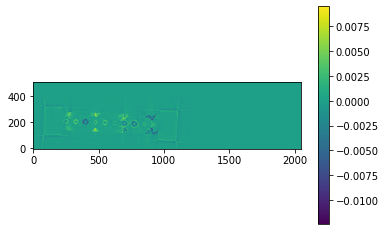

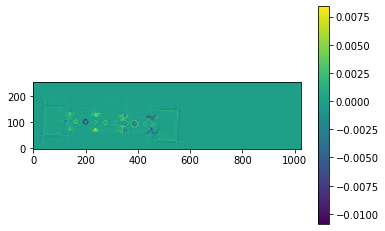

In [53]:
ds = zarr.open(OpenVisusStore("C:/visus_datasets/zip/visus.idx",quality=0), mode='r')
ShowImage(ds[ds.shape[0]//2,:,:])

ds = zarr.open(OpenVisusStore("C:/visus_datasets/zip/visus.idx",quality=-3), mode='r')
ShowImage(ds[ds.shape[0]//2,:,:])

Most interesting case is when I am OpenVisus with ZARR as a backend  i.e. OpenVisus reading/writing from/to the ZARR file format
so that any ZARR user can still access their data without using OpenVisus.

NOTE:
- each block/chunk will go in a separate file
- for local storage, I am using `DiskAccess`
- for cloud storage, I am using `CloudAccess` (untested)

The two access class have been extended to use `$(level)` and `$(block-offset)`

Filename template could look similar to:

```
visus/$(time)/$(field)/$(level)/$(block-offset)

# for example:

visus/0/data/21/0.0.0
```

Each directory containing a group will have a `.zgroup` file.
Eeach directory containing an array will have a  `.zarray` files

For not OpenVisus does not know how to create these files, and for this I am letting ZARR doing it

In [54]:
import math
sys.path.append("C:/projects/OpenVisus/build/RelWithDebInfo")
import OpenVisus as ov

# create the OpenVisus IDX file
img_filename="H:/My Drive/visus_dataset/arco/cat/image-stack/rgb.00.png"
arco=1024*1024
width,height,depth=256,256,256

field=ov.Field('data',"uint8[3]",'row_major')
bitsperblock = int(math.log2(arco // field.dtype.getByteSize())) 

samples_per_block=2**bitsperblock
blocksize=field.dtype.getByteSize(samples_per_block)

idx_filename="test/visus.idx"
db=ov.CreateIdx(url=idx_filename,  dims=[width,height,depth], fields=[field], bitsperblock=bitsperblock, arco=arco)
pdim=db.getPointDim()

def clist(value):
  return list(reversed([int(value[I]) for I in range(value.getPointDim())]))

# create the ZARR directory struture, one for each timestep/field/resolution
# this is needed to create zarr JSON files
root = zarr.group(store=zarr.DirectoryStore('test'))
visus_group=root.create_group("visus",overwrite=True)

for T in db.getTimesteps():
	time_group = visus_group.create_group(str(T),overwrite=True)
	for field in db.getFields():
		field_group = time_group.create_group(field,overwrite=True)
		blockid=0
		for level in range(bitsperblock, db.getMaxResolution()+1,1):
			level_samples=db.getLevelSamples(level)
			block_samples=db.getBlockQuerySamples(blockid)
   
			ov_field=db.getField(field)
			dtype=ov_field.dtype
			nchannels=dtype.ncomponents()
			single=dtype.get(0)
			dtype=str(np.dtype(single.toString()))
   
			ds = field_group.create_dataset(str(level), 
                                   shape =clist(level_samples.nsamples) + ([nchannels] if nchannels else []), 
                                   chunks=clist(block_samples.nsamples) + ([nchannels] if nchannels else []), 
                                   dtype=dtype,
                                   compressor=None
                                   )
			blockid=max(1,blockid*2)



# write binary data using DiskAccess with a ZARR-compatible filename template
import imageio.v2 as imageio

def Generator():
	img = imageio.imread(img_filename)
	for D in range(depth):
		yield img
		
  
access_config=ov.StringTree.fromString("""<access type='DiskAccess' compression="raw" layout="row_major" filename_template="test/visus/$(time)/$(field)/$(level)/$(block-offset)" />""")
access=db.createAccessForBlockQuery(access_config)
access.disableWriteLocks()
access.disableCompression()
db.writeSlabs(Generator(), access=access)

# IMPORTANT NOTE: **if you want to open this dataet in the visus viewer, you have to manually specify the access in yopur `visus.config`**

Not let's assume you are a ZARR user who wants to access the data without using OpenVisus. 

Since we are storing ZARR files (ie. using ZARR backend) this is now possible.
And if you open different resolutions, you could even have coarse-to-fine access

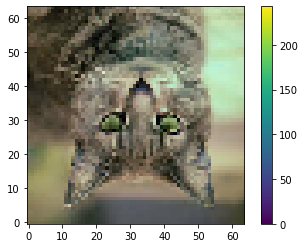

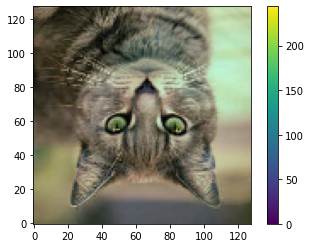

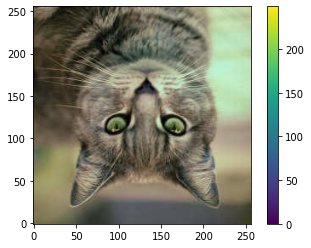

In [55]:
pdim=3
for level in range(24-2*pdim,24+1,pdim):
	timestep,fieldname=0,"data"
	filename=f'C:/projects/OpenVisus/test/visus/{timestep}/{fieldname}/{level}'
	ds = zarr.open(filename,  mode='r')
	data=ds[ds.shape[0]//2,:,:,:]
	ShowImage(data)